## Assignment - 3
### Author: Tony Joseph

In [1]:
'''
The Leung-Malik (LM) Filter Bank, implementation in python

T. Leung and J. Malik. Representing and recognizing the visual appearance of
materials using three-dimensional textons. International Journal of Computer
Vision, 43(1):29-44, June 2001.

Reference: http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
'''

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy

In [2]:
%matplotlib inline

In [3]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))
    
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g


In [4]:
def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

In [5]:
def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

In [6]:
def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

In [7]:
def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

In [8]:
F = makeLMfilters()
print(F.shape)

(49, 49, 48)


## First order derivative Gaussian Filter

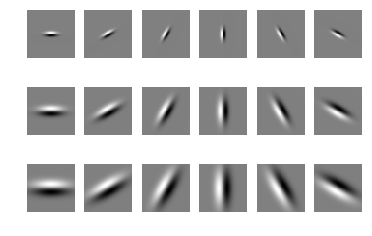

In [9]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')

## Second order derivative Gaussian Filter

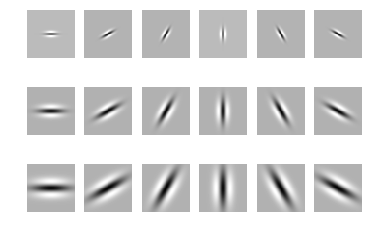

In [10]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+18], cmap = 'gray')

## Gaussian and Laplacian Filter

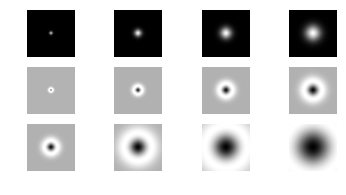

In [11]:
for i in range(0,12):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+36], cmap = 'gray')

In [14]:
def textureHist(img):

    dst = np.empty([img.shape[0],img.shape[1],F.shape[2]])

    plt.figure(figsize=(18,18))
    N= F.shape[2];
    for i in range(1, N):
        tmpdst = cv2.filter2D(img,-1,F[:,:,i])
    
        ret,tmpdst = cv2.threshold(tmpdst,tmpdst.max()*0.85,tmpdst.max(),cv2.THRESH_BINARY)
        tmpdst[tmpdst==255] = 1
        dst[:,:,i] = tmpdst
        
    for i in range(0,6):
        for j in range(0,8):
            plt.subplot2grid((6,8), (i,j)), plt.imshow(dst[:,:,((i)*8)+j], cmap='gray'),  plt.xticks([]), plt.yticks([])
    plt.show()

    hist = np.zeros(N)
    x = np.zeros(N)

    for i in range(1, N):
        dst[:,:,i] = dst[:,:,i]/(dst[:,:,i].max()+0.00001)
        hist[i] = np.sum(dst[:,:,i])/(img.shape[0]*img.shape[1])
        #hist[i] = np.sum(dst[:,:,i])  
        x[i] = i

    return x, hist

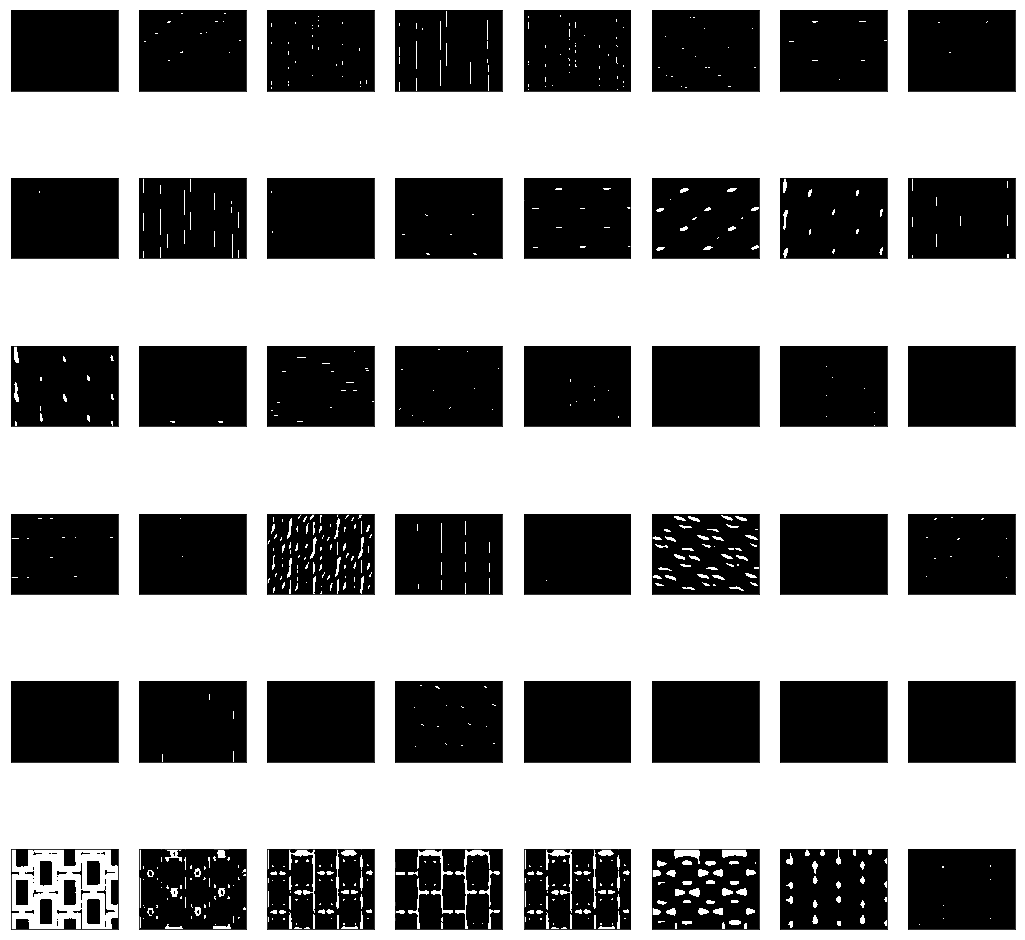

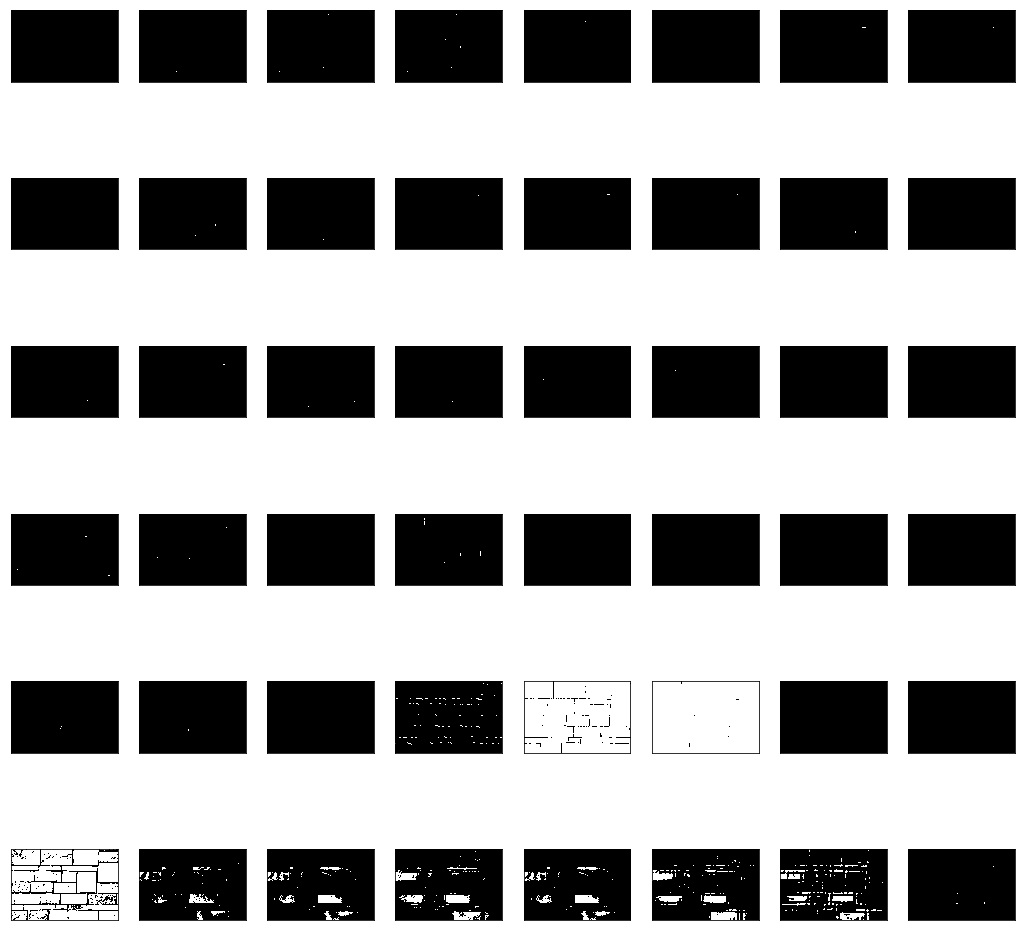

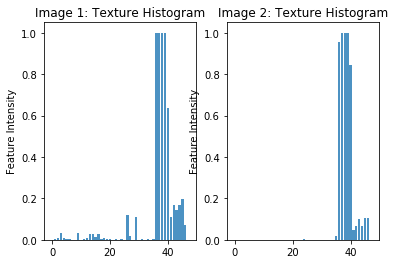

0.335171096364


In [25]:
img1 = cv2.imread('carpet.jpg',0);
img2 = cv2.imread('brick2.jpg',0);

hist1 = textureHist(img1)
hist2 = textureHist(img2)

N=48
x = np.zeros(N)
for i in range(1, N):
     x[i] = i
        
plt.subplot(1,2,1),
plt.bar(x, hist1, align='center', alpha=0.8)
plt.ylabel('Feature Intensity')
plt.title('Image 1: Texture Histogram')
plt.subplot(1,2,2),
plt.bar(x, hist2, align='center', alpha=0.8)
plt.ylabel('Feature Intensity')
plt.title('Image 2: Texture Histogram')

plt.show()

print(np.sqrt(sum((hist1-hist2)*(hist1-hist2))))
